# Lesson 6 HW

1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [54]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv('nursery.data', names=['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'recommend'])

- parents: usual, pretentious, great_pret
- has_nurs:       proper, less_proper, improper, critical, very_crit
- form:           complete, completed, incomplete, foster
- children:       1, 2, 3, more
- housing:        convenient, less_conv, critical
- finance:        convenient, inconv
- social:         non-prob, slightly_prob, problematic
- health:         recommended, priority, not_recom

In [56]:
df.sample(3)

,parents,has_nurs,form,children,housing,finance,social,health,recommend
7895,pretentious,very_crit,complete,3,convenient,inconv,nonprob,not_recom,not_recom
2935,usual,critical,completed,3,less_conv,convenient,nonprob,priority,spec_prior
9673,great_pret,less_proper,complete,more,convenient,convenient,problematic,priority,priority


In [57]:
df.rename(columns={'recommend': 'target'}, inplace=True)

In [58]:
df['target'].value_counts()

not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: target, dtype: int64

In [59]:
df['target'] = np.where(df.target == ('not_recom'), 0, df.target)
df['target'] = np.where(df.target != 0, 1, df.target)

In [60]:
df.target.value_counts()

1    8640
0    4320
Name: target, dtype: int64

In [61]:
class ColumnSelector(TransformerMixin, BaseEstimator):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.column]
    
class OHEencoder(TransformerMixin, BaseEstimator):
    def __init__(self, column):
        self.column = column
        self.columns = []
    
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.column).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.column)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [62]:
X = df.drop(columns='target')
y = df['target']

In [63]:
y = y.astype('int')

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   stratify=y, random_state=15)

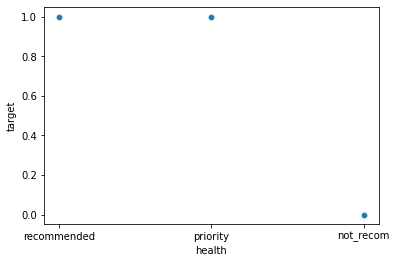

In [76]:
sns.scatterplot(data=df, y=df['target'], x=df['health'])
plt.show()

In [77]:
# признак health не берем из-за прямой корреляции с целевым
cat_columns = [
    'parents',
    'has_nurs',
    'form',
    'children',
    'housing',
    'finance',
    'social',
              ]

In [78]:
cat_transformers = []

for col in cat_columns:
    transformer = Pipeline([
                ('selector', ColumnSelector(column=col)),
                ('ohe', OHEencoder(column=col))
           ])
    cat_transformers.append((col, transformer))

In [79]:
feats = FeatureUnion(cat_transformers)

2. Обучить любой классификатор (какой вам нравится)

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
from xgboost import XGBClassifier

In [82]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=1))
])

In [83]:
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

In [84]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [85]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
ix = np.nanargmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.6305569557713075, F-Score=0.800, Precision=0.667, Recall=1.000


In [86]:
print(roc_auc_score(y_test, y_score))

0.4675543398014784


3. Разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные примеры (класс 1), а только лишь часть

4. Применить random negative sampling для построения классификатора в новых условиях

5. Сравнить качество с решением из пункта 3 (построить отчет - таблицу метрик)